# Load library

In [1]:
import os
if not os.getcwd().endswith('m6A'):
    os.chdir('m6A/')
%load_ext rpy2.ipython
from scripts.common import *
%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/homer/bin
data_folder='/home/dengw1/workspace/mouse_lowinput/'

env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/homer/bin


In [2]:
%%R
source('scripts/common.r')
data_folder<-'/home/dengw1/workspace/mouse_lowinput/'

# Preprocess (Clean data)

In [3]:
## Peak number
peak_num={}
for tissue in tissues:
    peak_num[tissue_full[tissue]]=len(open('idr_peak/%s_IDR.bed'%tissue).readlines())
pd.Series(peak_num).to_csv('m6A_data/peak_num',header=False,sep='\t')

gene_exp=defaultdict(lambda :defaultdict(float))
for tissue in tissues:
    for rep in ['1','2']:
        sample=tissue+'-Rep'+rep+'-Inp'
        group=tissue_full[tissue]+'_'+rep
        for line in open(
            '/home/dengw1/workspace/mouse_lowinput/FA233/kallisto/%s/abundance.tsv'%sample):
            if line.startswith('ENST'):
                info=line.strip().split('\t')
                gene=info[0].split('|')[1].split('.')[0]
                tpm=float(info[-1])
                gene_exp[group][gene]+=tpm
exp=pd.DataFrame.from_dict(gene_exp)

exp=pd.read_csv('m6A_data/FA233_exp_all_tx.txt',sep='\t',index_col=0,header=0)

for tissue in tissue_full.values():
    exp[tissue]=np.mean([exp['%s_1'%tissue],exp['%s_2'%tissue]],axis=0)
    exp.drop(columns=['%s_1'%tissue,'%s_2'%tissue],inplace=True)

exp.to_csv('m6A_data/FA233_exp_all_tx_mean.txt',sep='\t')


regulator_exp=pd.read_csv('m6A_data/regulator_exp.txt',sep='\t',index_col=0,header=0)

for tissue in tissue_full.values():
    regulator_exp[tissue]=np.mean([regulator_exp['%s_1'%tissue],regulator_exp['%s_2'%tissue]],axis=0)
    regulator_exp.drop(columns=['%s_1'%tissue,'%s_2'%tissue],inplace=True)

def reformat_header(header):
    return header.replace(' tissues_','Tissues_').replace(' system_','System_').replace(' ','')
regulator_exp=pd.read_csv('m6A_data/regulator_exp.txt',sep='\t',index_col=0,header=0)
regulator_exp.columns=[reformat_header(x) for x in regulator_exp.columns]
for tissue in tissue_full.values():
    regulator_exp[tissue]=np.mean([regulator_exp['%s_1'%tissue],regulator_exp['%s_2'%tissue]],axis=0)
    regulator_exp.drop(columns=['%s_1'%tissue,'%s_2'%tissue],inplace=True)

def reformat_header(header):
    return header.replace(' tissues_','Tissues_').replace(' system_','System_').replace(' ','')
regulator_exp.columns=[reformat_header(x) for x in regulator_exp.columns]
for tissue in tissue_full.values():
    regulator_exp[tissue]=np.mean([regulator_exp['%s_1'%tissue],regulator_exp['%s_2'%tissue]],axis=0)
    regulator_exp.drop(columns=['%s_1'%tissue,'%s_2'%tissue],inplace=True)

regulator_exp.to_csv('m6A_data/regulator_exp_mean.txt',sep='\t')

# Heatmap of differentiated m6A sites (Figure 1A, B)

In [3]:
%%R
peak_intensity<-read.table('m6A_data/peak_intensity_m_1_renamed_gmean.csv',sep='\t',header=T,row.names=1)
peak_intensity<-peak_intensity[complete.cases(peak_intensity),]
cvs<-apply(peak_intensity,1,cv)
cut=quantile(cvs,probs=c(0.9))
print(cut)

      90% 
0.6183365 


In [5]:
%%R
ht_opt$message = FALSE
vdata<-subset(peak_intensity,cvs>=cut)
vdata<-vdata[complete.cases(vdata),]
print(dim(vdata))

[1] 5735   66


png 
  2 


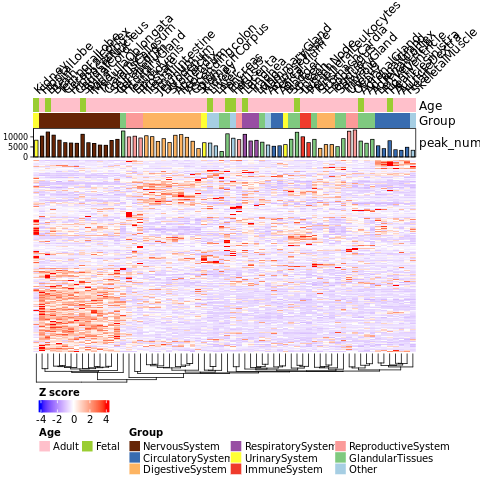

In [5]:
%%R
ht_opt$message = FALSE
vdata<-subset(peak_intensity,cvs>=cut)
vdata<-vdata[complete.cases(vdata),]
mat=t(scale(t(as.matrix(vdata))))
# Requires free RAM > 10GB

spl<-t(as.data.frame(strsplit(colnames(mat),'_')))
colnames(spl)<-c('Group','Age','Tissue')
tissue_group<-as.vector(spl[,'Group'])
tissue_age<-as.vector(spl[,'Age'])

peak_num_<-read.csv('m6A_data/peak_num',sep='\t',header=F,row.names=1)

peak_num_<-peak_num_[colnames(mat),1]

group_color=c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99",
              "#984ea3","#ffff33")
group_order=c("NervousSystem","CirculatorySystem","DigestiveSystem",
                        "RespiratorySystem","UrinarySystem","ImmuneSystem",
                        "ReproductiveSystem","GlandularTissues","Other")
names(group_color)<-unique(tissue_group)

column_ha=HeatmapAnnotation(
  Age=tissue_age,
  Group=tissue_group,
  peak_num = anno_barplot(peak_num_,gp = gpar(fill =group_color[tissue_group]),width = unit(2, "cm")),
  col=list(Age=c("Adult"="pink","Fetal"="yellowgreen"),Group=group_color),
  annotation_legend_param = list(
      Age = list(direction = "horizontal",nrow = 1),
      Group = list(direction = "horizontal",nrow = 3,
                   at=group_order))
)

col_fun = colorRamp2(c(-4, 0, 4), c("blue", "white", "red"))
colnames(mat)<-spl[,'Tissue']
hm=Heatmap(mat,name="Z score",top_annotation  = column_ha,show_row_name=F,show_column_name=T,
        col=col_fun,show_row_dend =F, heatmap_legend_param = list(direction = "horizontal"),column_names_rot = 45, 
           column_names_side = "top", column_dend_side = "bottom") 

draw(hm, heatmap_legend_side = "bottom", annotation_legend_side = "bottom")

pdf('figures/Figure1AB_peak_intensity.pdf',width=9,height=7)
draw(hm, heatmap_legend_side = "bottom", annotation_legend_side = "bottom")
dev.off()

# Figure S2

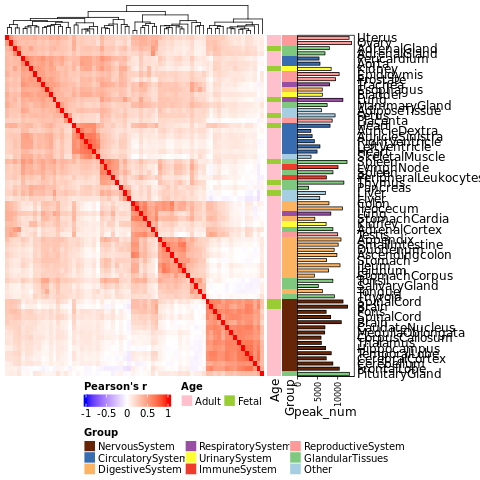

In [10]:
%%R
vdata<-subset(peak_intensity,cvs>=cut)
res2 <- rcorr(as.matrix(vdata))

corr_<-as.matrix(res2$r)

spl<-t(as.data.frame(strsplit(colnames(corr_),'_')))
colnames(spl)<-c('Group','Age','Tissue')
tissue_group<-as.vector(spl[,'Group'])
tissue_age<-as.vector(spl[,'Age'])

peak_num_<-read.csv('m6A_data/peak_num',sep='\t',header=F,row.names=1)

peak_num_<-peak_num_[colnames(corr_),1]

group_color=c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")
names(group_color)<-unique(tissue_group)


row_ha=rowAnnotation(
  Age=tissue_age,
  Group=tissue_group,
  peak_num = anno_barplot(peak_num_,gp = gpar(fill =group_color[tissue_group]),width = unit(2, "cm")),
  col=list(Age=c("Adult"="pink","Fetal"="yellowgreen"),Group=group_color),
  annotation_legend_param = list(
      Age = list(direction = "horizontal",nrow = 1),
      Group = list(direction = "horizontal",nrow = 3,at=c("NervousSystem","CirculatorySystem","DigestiveSystem",
                                                          "RespiratorySystem","UrinarySystem","ImmuneSystem",
                                                          "ReproductiveSystem","GlandularTissues","Other")))
    
  )
# 
pdf('figures/Figure1_S2_corr_peak_intensity2.pdf',width=9,height=8)
col_fun = colorRamp2(c(-1, 0, 1), c("blue", "white", "red"))
rownames(corr_)<-spl[,'Tissue']

hm=Heatmap(corr_,name="Pearson's r",right_annotation  = row_ha,show_row_name=T,show_column_name=F,
        col=col_fun,show_row_dend =F, heatmap_legend_param = list(direction = "horizontal")) 

draw(hm, heatmap_legend_side = "bottom", annotation_legend_side = "bottom")
dev.off()
draw(hm, heatmap_legend_side = "bottom", annotation_legend_side = "bottom")


# Figure S3

In [13]:
%%R
data<-read.table('m6A_data/regulator_exp_mean.txt',sep='\t',header = T,row.names=1)
mat=t(scale(t(as.matrix(data))))


spl<-t(as.data.frame(strsplit(colnames(data),'_')))
colnames(spl)<-c('Group','Age','Tissue')
colnames(mat)<-spl[,'Tissue']

Gene_level=c('Writer','Reader','Eraser')
Gene_group=c('Reader','Reader','Reader','Reader','Reader','Reader','Reader',
             'Reader','Reader','Reader','Reader','Eraser','Eraser',
             'Writer','Writer','Writer','Writer','Writer','Writer')

row_ha=rowAnnotation(Function=Gene_group,
                     col=list(Function=c('Writer'='darkslategray1','Reader'='darkseagreen1',
                                         'Eraser'='darkorchid1')))
column_ha2=HeatmapAnnotation(
  Age=tissue_age,
  Group=tissue_group,
  col=list(Age=c("Adult"="pink","Fetal"="yellowgreen"),Group=group_color),
  annotation_legend_param = list(
      Age = list(direction = "horizontal",nrow = 1),
      Group = list(direction = "vertical",nrow = 9,
                   at=c("NervousSystem","CirculatorySystem","DigestiveSystem",
                        "RespiratorySystem","UrinarySystem","ImmuneSystem",
                        "ReproductiveSystem","GlandularTissues","Other")))
)
pdf('figures/Figure1_S3_reg_exp_n.pdf',width=25,height=15)
p<-Heatmap(mat,name='z-score',top_annotation  = column_ha2,
           right_annotation = row_ha,show_column_dend=F)
draw(p)
dev.off()

png 
  2 


   # Figure 1E

png 
  2 


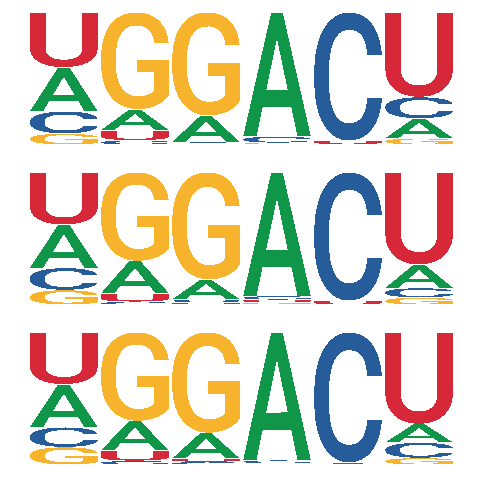

In [90]:
%%R
demo_tissue<-c('ABR','AHE','ASI') # Adult brain, adult heart and adult small intestine
plot_data = function (tissue) {
    seq_matrix<-read.csv(paste0(data_folder,'/FA233/homer/',tissue,'_IDR/homerResults/motif1.motif'),skip=1,sep='\t')
    colnames(seq_matrix)=c('A','C','G','U')
    seq_matrix<-t(seq_matrix)
    ggplot() + geom_logo(seq_matrix, method = 'prob') + theme_logo() +
    theme(axis.text.x = element_blank(),panel.spacing = unit(0.5, 'lines'),
        axis.text.y = element_blank(),axis.title.y = element_blank(),axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=30, face='bold'),legend.position = 'none') 
}

figs <- lapply(demo_tissue, plot_data)

print(ggarrange(plotlist=figs,nrow=3))

pdf('figures/Figure1D_seqlog.pdf')
print(ggarrange(plotlist=figs,nrow=3))
dev.off()

# Figure 1F

In [7]:
system_tissue=defaultdict(list)
for tissue in tissues:
    system=tissue_full[tissue].split('_')[0]#.replace('System','')
    system_tissue[system].append(tissue)
for system in system_tissue:
    final_df=None
    for tissue in system_tissue[system]:
        df_t=pd.read_csv('idr_peak/%s_IDR.bed'%tissue,header=None,sep='\t',names=list('ABCDEFGHIJ'))
        if final_df is None:
            final_df=df_t
        else:
            final_df=pd.concat([final_df,df_t],ignore_index=True)
    final_df=final_df.drop_duplicates(subset=list('ABCEF'))
    final_df.to_csv('m6A_data/%s_IDR.bed'%system,sep='\t',quoting=csv.QUOTE_NONE,header=False,index=False)

def one(tissue):
    ret=subprocess.check_output('python3 scripts/Peak_distribution_on_utr_cds.py m6A_data/%s_IDR.bed'%tissue,
                                shell=True).decode('utf-8')
    return [tissue,ret]


pool=Pool(processes=25)
all_=pool.map(one,system_tissue.keys())
pool.close()
pool.join()

fo=open('m6A_data/IDR_dist.txt','w')

for item in all_:
    info=item[1].strip().split('\n')
    for i in range(len(info)):
        fo.write('%s\t%s\t%s\n'%(item[0],i+1,info[i].split('\t')[1]))
fo.close()

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



png 
  2 


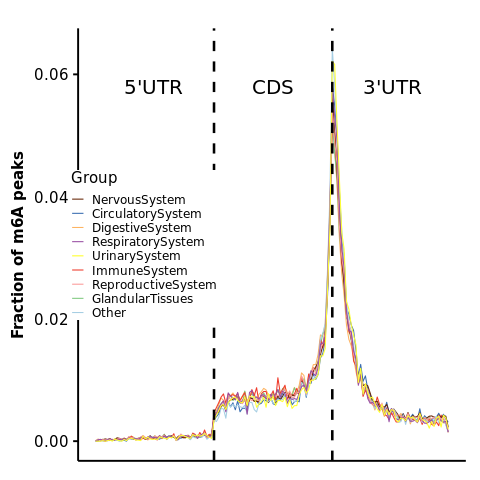

In [8]:
%%R
df_dist<-read.table('m6A_data/IDR_dist.txt')
colnames(df_dist)<-c('Group','X','Y')

sep1=51
sep2=101
p<-ggplot(df_dist,aes(x=X,y=Y,color=Group))+geom_line(size=0.5)+
geom_vline(xintercept=c(sep1, sep2), linetype='dashed', size = 1.2) +
  annotate('text', label=c("5'UTR", "CDS", "3'UTR"), size = 7,x=c( sep1/2, (sep1+sep2)/2, sep2+sep1/2 ),
           y=max(df_dist[,3])*0.9)  +
#     scale_x_continuous(expand=c(0,0)) + 
    ylab('Fraction of m6A peaks')+
    scale_colour_Publication()+ theme_Publication()+
    theme(panel.spacing = unit(0.5, 'lines'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank(),
        text = element_text(size=15),
        axis.text.y = element_text(size=15),
        axis.title.y = element_text(size=15),
        legend.position = c(0.17,0.5))+guides(color=guide_legend(ncol=1,title.position='top'))+
        scale_color_manual(values=group_color,breaks=group_order)
print(p)
pdf('figures/Figure1C_distribution.pdf',height=4.5)
print(p)
dev.off()

# Figure 1C

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



png 
  2 


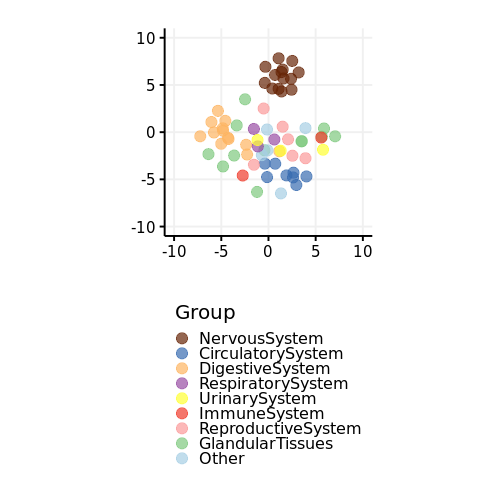

In [9]:
%%R
tsne_mat=Rtsne(t(peak_intensity),labels=tissue_group,perplexity =10)
tnse_mat_matrix=as.data.frame(tsne_mat$Y)
tnse_mat_matrix$Group=factor(tissue_group,level=group_order)


p<-ggplot(tnse_mat_matrix, aes(x=V1, y=V2)) + 
  scale_x_continuous(limits=c(-10, 10))+
  scale_y_continuous(limits=c(-10, 10))+
  scale_colour_Publication()+ 
  theme_Publication()+
  theme(
      aspect.ratio=1,
      axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      legend.position = 'bottom')+
      guides(color=guide_legend(ncol=1,title.position='top'))+ 
  geom_point(aes(colour = Group),size=5,alpha=0.7)+ylab('')+xlab('')+
  scale_color_manual(values=group_color,breaks=group_order)

print(p)
pdf('figures/Figure1E_tsne_gmean.pdf',width=9,height=9)
print(p)
dev.off() 

# Figure 1D

In [10]:
def read_peak_file(fn, peak_to_gene=None):
    peak_dict = {}
    if peak_to_gene is None:
        peak_to_gene = {}
    with open(fn, 'r') as f:
        for line in f:
            ele = line.strip().split()
            peak = ':'.join(ele[0:3])+':'+ele[5]
            score = float(ele[-4])
            gene = ele[3].split('-')[0]
            peak_dict[peak] = score
            peak_to_gene[peak] = gene
    return peak_dict, peak_to_gene

project_dir =  'idr_peak'
peak_to_gene = dict()
peak_dict = dict()
peak_fn_list= [os.path.join(project_dir, x) for x in os.listdir(project_dir) if
                    x.endswith('IDR.bed')]
for peak_fn in peak_fn_list:
    peak_name = peak_fn.split('/')[-1].split('_')[0]
    tmp, peak_to_gene = read_peak_file(peak_fn, peak_to_gene)
    peak_dict[peak_name] = tmp
    print(peak_name,end=',')

df_with_sig = pd.DataFrame.from_dict(peak_dict)
pd.Series(peak_to_gene).to_csv('m6A_data/peak2gene.txt',sep='\t',header=False)
df_with_sig.to_csv('m6A_data/sig_peaks_raw.txt',sep='\t')

AAC,AAD,AAG,AAO,AAP,AAS,AAT,ABL,ABR,ACA,ACC,ACE,ACL,ACN,ACO,ACS,ADU,AEP,AES,AFL,AHE,AHI,AIC,AIM,AJE,AKI,ALE,ALI,ALN,ALU,ALV,AMG,AMO,AOV,APA,APE,APG,APL,APO,APR,ARV,ASC,ASG,ASI,ASM,ASO,ASP,AST,ATA,ATE,ATG,ATL,ATN,ATR,ATY,AUT,FAG,FBR,FHE,FKI,FLI,FLU,FSC,FSP,FTH,FWH,

png 
  2 


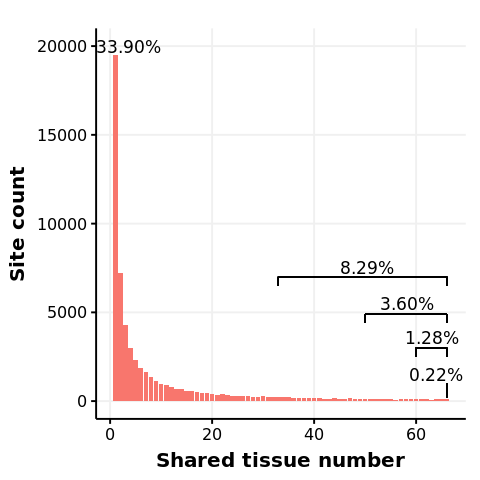

In [88]:
%%R
df<-read.csv('m6A_data/sig_peaks_raw.txt',sep='\t',header=T,row.names=1)
df[is.na(df)]<-0
df[df>0]<-1
df$Sum=rowSums(df)
tx_stack<-''

max_y<-nrow(df[df$Sum==1,])
for(i in c(1:66)){
    xx<-df[df$Sum==i,]
     tx_stack<-paste0(tx_stack,paste(c(i,nrow(xx)),collapse=','),'\n')
}
stack_data<-read.csv(text=tx_stack,header=F)
colnames(stack_data)<-c('x','Number')

p<-ggplot(stack_data, aes(y=Number, x=x,fill='brown')) + 
    geom_bar(stat="identity")+
    theme_Publication()+ylab('Site count')+theme(legend.position='none')+xlab('Shared tissue number')+
    annotate('text',label='33.90%', x=1,y=20000,hjust=0.3,size=6)+
    annotate('text',label='0.22%', x=66,y=1500,hjust=0.7,size=6)+
    geom_segment(x=66,y=200,xend=66,yend=1000)+

    annotate('text',label='1.28%', x=60,y=3600,hjust=0.2,size=6)+
    geom_segment(x=60,y=3000,xend=66,yend=3000)+
    geom_segment(x=60,y=2500,xend=60,yend=3000)+
    geom_segment(x=66,y=2500,xend=66,yend=3000)+

    annotate('text',label='3.60%', x=53,y=5500,hjust=0,size=6)+
    geom_segment(x=50,y=4900,xend=66,yend=4900)+
    geom_segment(x=50,y=4400,xend=50,yend=4900)+
    geom_segment(x=66,y=4400,xend=66,yend=4900)+

    annotate('text',label='8.29%', x=45,y=7500,hjust=0,size=6)+
    geom_segment(x=33,y=7000,xend=66,yend=7000)+
    geom_segment(x=33,y=6500,xend=33,yend=7000)+
    geom_segment(x=66,y=6500,xend=66,yend=7000)
print(p)

pdf('figures/Figure1F_HP_all.pdf',width=11)
print(p)
dev.off()

In [ ]:
# Figure S2B

png 
  2 


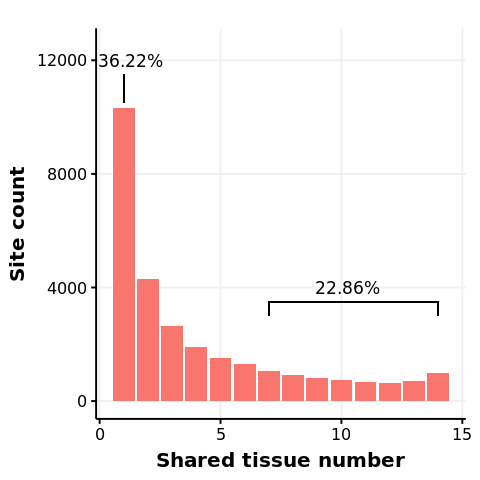

In [89]:
%%R
brain_ts<-c("ABR","ACN","ACE","ACC","ACO","AFL","AHI","AMO","APO","ASC","ATL","ATA","FBR","FSC")

df<-read.csv('m6A_data/sig_peaks_raw.txt',sep='\t',header=T,row.names=1)
df<-df[,brain_ts]
df[is.na(df)]<-0
df[df>0]<-1
df$Sum=rowSums(df)
tx_stack<-''

max_y<-nrow(df[df$Sum==1,])
for(i in c(1:14)){
    xx<-df[df$Sum==i,]
     tx_stack<-paste0(tx_stack,paste(c(i,nrow(xx)),collapse=','),'\n')
}
stack_data<-read.csv(text=tx_stack,header=F)
colnames(stack_data)<-c('x','Number')

p<-ggplot(stack_data, aes(y=Number, x=x,fill='brown')) + 
    geom_bar(stat="identity")+
    theme_Publication()+ylab('Site count')+theme(legend.position='none')+xlab('Shared tissue number')+ylim(0,12500)+
    annotate('text',label='36.22%', x=1,y=12000,hjust=0.4,size=6)+
    geom_segment(x=1,y=10500,xend=1,yend=11500)+
    geom_segment(x=7,y=3000,xend=7,yend=3500)+
    geom_segment(x=7,y=3500,xend=14,yend=3500)+
    geom_segment(x=14,y=3500,xend=14,yend=3000)+
    annotate('text',label='22.86%', x=10,y=4000,hjust=0.4,size=6)

print(p)

pdf('figures/Figure1_S2B_HP_Brain.pdf',width=11)
print(p)
dev.off()